In [2]:
import os
os.chdir("./src")
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import config
config.normal_class_index_list = [0,1,2,3,4]
import data_util.news20
newsdata = data_util.news20.news20_Dataset('../data')
newsdata.preprocess_for_sentiment_understanding()
dataset = newsdata.get_binary_labeled_data() 

cuda


[nltk_data] Downloading package stopwords to /home/qudgks/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/qudgks/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


embedding with s_bert embedding


In [4]:
# from sklearn.mixture import GaussianMixture
# gm = GaussianMixture(n_components=4, random_state=0).fit_predict(dataset['train_x'].numpy())
# gm.shape
from sklearn.cluster import KMeans
cluster_model = KMeans(n_clusters=4, random_state = 0).fit(dataset['train_x'].numpy())
cluster_model.labels_

array([3, 3, 2, ..., 1, 3, 2], dtype=int32)

In [5]:
import umap
mapper = umap.UMAP(n_neighbors=15,random_state=42)
emb = pd.DataFrame(mapper.fit_transform(dataset['train_x'].numpy()), columns=['x','y'])

Text(0.5, 1.0, 'GT score')

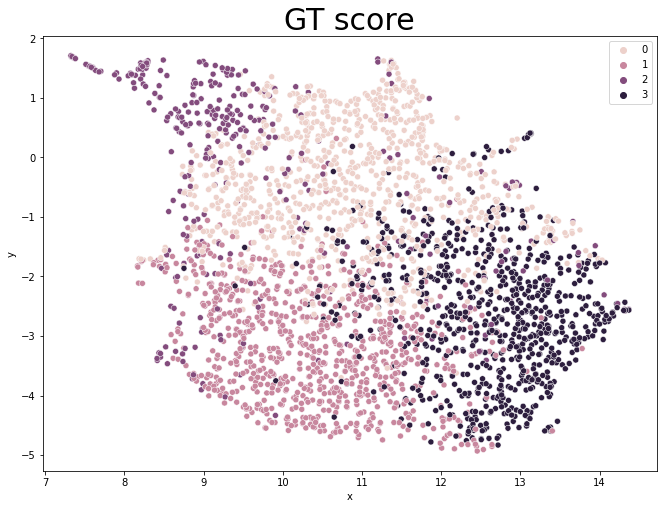

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(11, 8))
fig = sns.scatterplot(data = emb, x='x',y="y", hue=cluster_model.labels_)
plt.setp(fig.get_legend().get_texts(), fontsize='10')
plt.setp(fig.get_legend().get_title(), fontsize='10')
plt.title("GT score",fontsize="30")


In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
def get_scores_one_cluster(ftrain, ftest, food, shrunkcov=False):
    if shrunkcov:
        print("Using ledoit-wolf covariance estimator.")
        cov = lambda x: ledoit_wolf(x)[0]
    else:
        cov = lambda x: np.cov(x.T, bias=True)

    # ToDO: Simplify these equations
    dtest = np.sum(
        (ftest - np.mean(ftrain, axis=0, keepdims=True))
        * (
            np.linalg.pinv(cov(ftrain)).dot(
                (ftest - np.mean(ftrain, axis=0, keepdims=True)).T
            )
        ).T,
        axis=-1,
    )

    dood = np.sum(
        (food - np.mean(ftrain, axis=0, keepdims=True))
        * (
            np.linalg.pinv(cov(ftrain)).dot(
                (food - np.mean(ftrain, axis=0, keepdims=True)).T
            )
        ).T,
        axis=-1,
    )

    return dtest, dood

In [8]:
def get_scores_multi_cluster(ftrain, ftest, food, ypred):
    xc = [ftrain[ypred == i] for i in np.unique(ypred)]

    din = [
        np.sum(
            (ftest - np.mean(x, axis=0, keepdims=True))
            * (
                np.linalg.pinv(np.cov(x.T, bias=True)).dot(
                    (ftest - np.mean(x, axis=0, keepdims=True)).T
                )
            ).T,
            axis=-1,
        )
        for x in xc
    ]
    dood = [
        np.sum(
            (food - np.mean(x, axis=0, keepdims=True))
            * (
                np.linalg.pinv(np.cov(x.T, bias=True)).dot(
                    (food - np.mean(x, axis=0, keepdims=True)).T
                )
            ).T,
            axis=-1,
        )
        for x in xc
    ]

    din = np.min(din, axis=0)
    dood = np.min(dood, axis=0)

    return din, dood

In [9]:
#din, dood = get_scores_one_cluster(dataset['train_x'].numpy(),dataset['test_in'].numpy(),dataset['test_out'].numpy())

In [10]:
din, dood = get_scores_multi_cluster(dataset['train_x'].numpy(),dataset['test_in'].numpy(),dataset['test_out'].numpy(),cluster_model.labels_)

In [11]:
np.unique(dood)

array([ 163.49999694,  316.48892835,  316.82146646, ..., 2737.41218974,
       2833.46488832, 2938.22841181])

In [12]:
n = ["normal" for i in range(len(dataset['test_in'].numpy()))]
N = ["abnormal" for i in range(len(dataset['test_out'].numpy()))]
n.extend(N)

In [13]:
dd = np.append(din, dood)

In [14]:
import matplotlib.pyplot as plt
test = np.vstack([dataset['test_in'].numpy(),dataset['test_out'].numpy()])
mapper = umap.UMAP(n_neighbors=15,random_state=42)
emb = pd.DataFrame(mapper.fit_transform(test), columns=['x','y'])
emb['label_gt'] = n
emb["score"] = dd

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Text(0.5, 1.0, 'GT score')

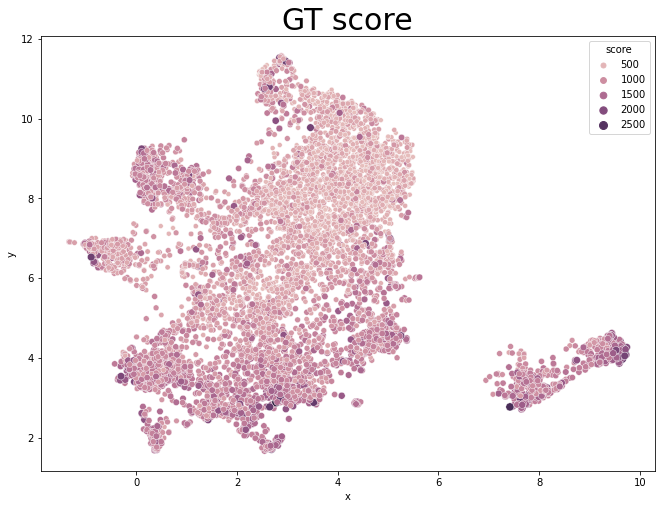

In [15]:
plt.figure(figsize=(11, 8))
fig = sns.scatterplot(data = emb, x='x',y="y", hue="score", size ='score')
plt.setp(fig.get_legend().get_texts(), fontsize='10')
plt.setp(fig.get_legend().get_title(), fontsize='10')
plt.title("GT score",fontsize="30")

Text(0.5, 1.0, 'GT score')

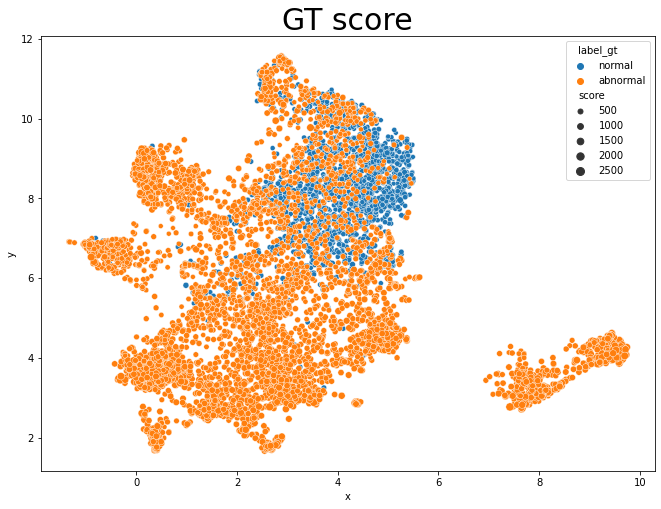

In [16]:
plt.figure(figsize=(11, 8))
fig = sns.scatterplot(data = emb, x='x',y="y", hue="label_gt", size ='score')
plt.setp(fig.get_legend().get_texts(), fontsize='10')
plt.setp(fig.get_legend().get_title(), fontsize='10')
plt.title("GT score",fontsize="30")

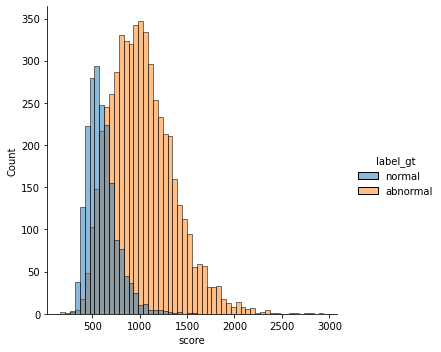

In [17]:
fig = sns.displot(emb, x="score", hue="label_gt")

In [18]:
emb['score']

0        434.356462
1        517.756823
2        919.866501
3        749.285531
4        637.460619
           ...     
7294    1074.768729
7295     690.491511
7296     909.797270
7297     491.457789
7298    1046.787325
Name: score, Length: 7299, dtype: float64

In [19]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
n = [0 for i in range(len(dataset['test_in'].numpy()))]
N = [1 for i in range(len(dataset['test_out'].numpy()))]
n.extend(N)
fpr, tpr, thresholds=roc_curve(n,emb['score'], pos_label=0)
auroc = auc(fpr,tpr)

In [20]:
auroc

0.10826730330210087

In [21]:
roc_auc_score(n,emb['score'])

0.891732696697899

In [22]:
# matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Logistic Regression')
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='KNN')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

NameError: name 'fpr1' is not defined